# Applied Data Analysis - Fall 2016
## Twitter-Swisscom Project

### Mobility Pattern: Data Wrangling


1 - [Load the data](#load_data)

2 - [Cleaning](#cleaning)

3 - [Exploratory and Analysis](#exploratory_analysis)

In [1]:
import pandas as pd
import math
import numpy as np
from mobility_helper import *
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import time
from geopy.geocoders import Nominatim,Bing
import datetime as dt
import folium

### 1 - <a id='load_data'>Load the data</a> 

Contains subset of the original schema. Already removed useless columns for mobility pattern at preprocessing:
1. id
2. userID
3. createdAt
4. longitude
5. latitude
6. placeID
7. placeLatitude
8. placeLongitude
9. sourceName
10. userLocation

In [2]:
src = '../twitter-swisscom/mobility/twex_mobility_corrected.tsv'
columns = ['ID', 'userID', 'createdAt', 'longitude', 'latitude', 'placeID','placeLatitude','placeLongitude','sourceName', 'userLocation']
dtypes = {'ID': 'int', 'createdAt': 'str', 'longitude': 'float', 'latitude': 'float', 'placeID': 'str', 'placeLatitude': 'float', 'placeLongitude': 'float', 'sourceName': 'str', 'userLocation': 'str'}

chunk_size = 10**6
df = pd.read_csv(src, sep='\t', names=columns, na_values=['\\N'],dtype=dtypes, encoding='utf-8')

### 2 - <a id='cleaning'>Cleaning</a>

We check the number of rows with null latitude.

In [3]:
print(len(df[pd.isnull(df.latitude)]))

6308709


Number of null longitude.

In [4]:
print(len(df[pd.isnull(df.longitude)]))

6308709


Number of tweets with both latitude and longitude null.

In [5]:
no_coord = np.logical_and(pd.isnull(df.latitude), pd.isnull(df.longitude))
tw_wo_coord = df[no_coord]
print(len(tw_wo_coord))

6308709


We get the same numbers. Thus one is never null without the second also null.

We now check if the place coordinates exists in case of null original coordinates.

In [6]:
has_place_coord = tw_wo_coord[~np.logical_and(pd.isnull(tw_wo_coord.placeLatitude), pd.isnull(tw_wo_coord.placeLongitude))]
len(has_place_coord)

6308709

We see that they always exist. This imply that we can replace the original coordinates by the place coordinates in case of nullity.

In [7]:
df['latitude'] = df.apply(replaceLatitude, axis=1)
df['longitude'] = df.apply(replaceLongitude, axis=1)

We check the number of tweets with no coordinates now.

In [8]:
no_coord = np.logical_and(pd.isnull(df.latitude), pd.isnull(df.longitude))
len(df[no_coord])

0

We do not have NaN coordinates. We can now safely drop the place coordinates columns since they are no longer of use to us.

In [9]:
df = df.drop(['placeID', 'placeLatitude', 'placeLongitude'], axis=1)
df.head()

,ID,userID,createdAt,longitude,latitude,sourceName,userLocation
0,924163322,17341045,2010-02-23 05:55:51,7.43926,46.9489,TwitBird,"Bern, Switzerland"
1,924911820,7198282,2010-02-23 06:22:40,8.53781,47.3678,Gowalla,"Zurich, Switzerland"
2,926639767,14657884,2010-02-23 07:34:25,6.13396,46.1951,foursquare,"Geneva, Switzerland"
3,927018013,14703863,2010-02-23 07:51:47,8.81749,47.2288,Twittelator,"Zürich, Switzerland"
4,927264351,14393717,2010-02-23 08:02:57,6.63254,46.5199,foursquare,"Lausanne, Suisse"


We now look at timestamps. We start by checking the nullity of each row.

In [10]:
print(len(df[pd.isnull(df.createdAt)]))

0


There are no tweets without timestamp.

We now want to have tweets in the area of Switzerland with pieces of the neighboring countries. We thus filter by latitude and longitude. we define the following bounds:
- 45 <= latitude <= 48
- 4 <= longitude <= 13
We remove the potential outliers.

In [11]:
print(len(df))
lat_inbound = ((45 <= df.latitude) & (df.latitude <= 48))
long_inbound = ((4 <= df.longitude) & (df.longitude <= 13))
inbound = np.logical_and(lat_inbound, long_inbound)
print(len(df[~inbound]))
df = df[inbound]

16089761
1826


We decide to remove the sourceName field. We wanted to see if we could emphasize on the source of the sending: Desktop or mobile. Since the majority of sources are coming from mobile apps it is of no use to us. We remove the corresponding column

In [12]:
df = df.drop(['sourceName'], axis=1)
df.head()

,ID,userID,createdAt,longitude,latitude,userLocation
0,924163322,17341045,2010-02-23 05:55:51,7.43926,46.9489,"Bern, Switzerland"
1,924911820,7198282,2010-02-23 06:22:40,8.53781,47.3678,"Zurich, Switzerland"
2,926639767,14657884,2010-02-23 07:34:25,6.13396,46.1951,"Geneva, Switzerland"
3,927018013,14703863,2010-02-23 07:51:47,8.81749,47.2288,"Zürich, Switzerland"
4,927264351,14393717,2010-02-23 08:02:57,6.63254,46.5199,"Lausanne, Suisse"


### 3 - <a id='exploratory_analysis'>Data exploration and Analysis</a> 

We first want to look at the distribution of our coordinates.

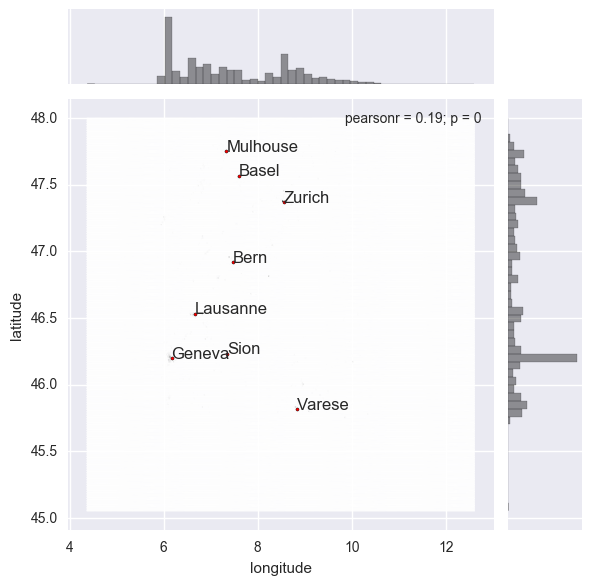

In [13]:
main_cities = {
    'Zurich': [47.36667, 8.55000],
    'Geneva':[46.2,6.1667],
    'Basel': [47.5667,7.6],
    'Bern' : [46.9167,7.4667],
    'Lausanne': [46.5333,6.6667],
    'Sion': [46.2333,7.35],
    'Varese': [45.8176,8.8264],
    'Mulhouse': [47.75, 7.3333],
}
g = sns.jointplot(x=df.longitude, y=df.latitude, kind="hex", color="k");
for city, coord in main_cities.items():
    g.ax_joint.scatter(coord[1], coord[0], marker='o', c='r', s=5)
    g.ax_joint.annotate(city, xy=(coord[1], coord[0]), xytext=(coord[1], coord[0]))
plt.show()

We can see that our coordinate are mostly concentrated in the big cities of Switzerland as well as some  bordering cities.

After looking at the user location we see that this information is messy and frequently useless to us. It is too difficult to detect and use this field when it adds good information. We remove the column.

In [14]:
df = df.drop(['userLocation'], axis=1)
df.head()

,ID,userID,createdAt,longitude,latitude
0,924163322,17341045,2010-02-23 05:55:51,7.43926,46.9489
1,924911820,7198282,2010-02-23 06:22:40,8.53781,47.3678
2,926639767,14657884,2010-02-23 07:34:25,6.13396,46.1951
3,927018013,14703863,2010-02-23 07:51:47,8.81749,47.2288
4,927264351,14393717,2010-02-23 08:02:57,6.63254,46.5199


We group our tweets by users and check the distribution of tweets per user.

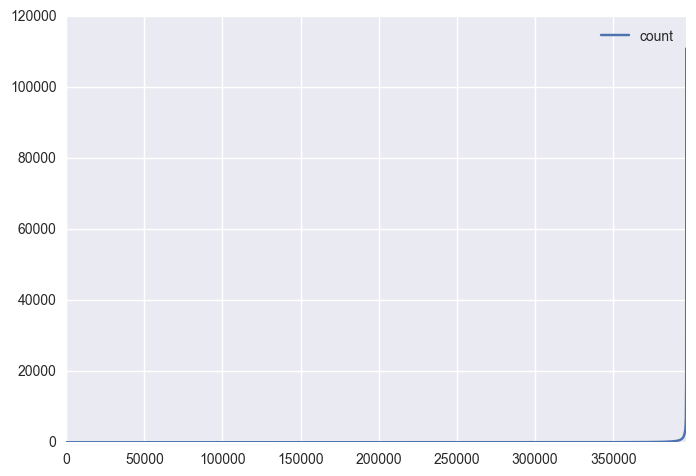

In [15]:
count_users = pd.DataFrame(df.groupby(['userID']).size())
count_users.columns = ['count']
count_users = count_users.sort_values(by=['count'], ascending=True)
count_users = count_users.reset_index()

count_users.plot(y='count', use_index=True)
plt.show()

We observe than 5% of our users wrote more than 90% of our tweets. This means that our number of users will drastically be inferior to the number of tweets we have. Also, this also mean that we have a lot of users that wrote very few tweets. Since we want to do statistics about users locations and movement we should remove those users.

We remove users who wrote less than 100 of tweets. We will loose a high number of users but the ones we keep will have enough data to obtain statistics of minimum quality.

In [16]:
threshold = 100
before = len(count_users)
count_users = count_users[count_users['count'] >= threshold]
after = len(count_users)
print('Percentage of user loss: ',(before-after)*100/before)

#list of ids to keep
#DataFrame 'tweets' is the filtered version of our first 'df'
ids_to_keep = list(count_users.userID)
tweets = df[df.userID.isin(ids_to_keep)]
len(tweets)

Percentage of user loss:  95.34406577590921


13186324

We now check our timestamps. We want to know if we have tweets without timestamps and we want to convert those into datetime objects for future uses.

Check the types:

In [17]:
tweets.dtypes

ID             int32
userID         int64
createdAt     object
longitude    float64
latitude     float64
dtype: object

Let's convert them.

In [18]:
tweets['createdAt'] = pd.DatetimeIndex(tweets['createdAt'])
tweets.dtypes

C:\Users\Alain\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


ID                    int32
userID                int64
createdAt    datetime64[ns]
longitude           float64
latitude            float64
dtype: object

In [19]:
tweets = tweets.reset_index(drop=True)
tweets.head()

,ID,userID,createdAt,longitude,latitude
0,924163322,17341045,2010-02-23 05:55:51,7.43926,46.9489
1,924911820,7198282,2010-02-23 06:22:40,8.53781,47.3678
2,926639767,14657884,2010-02-23 07:34:25,6.13396,46.1951
3,927264351,14393717,2010-02-23 08:02:57,6.63254,46.5199
4,928080163,14393717,2010-02-23 08:40:13,6.63428,46.5191


We cleaned our dataset and save the obtained dataframe.

In [20]:
tweets.to_csv('./data/tweets_processed.csv', encoding='utf-8', index=False)